# CE 5362 Lesson 5 Computational Workshop

This computational workshop is to examine computation related to:

1. Uniform flow; algebraic equation.
$$ S_f = S_0 $$

2. Gradually varied; ordinary differential equation.
$$ S_f = S_0 - \frac{\partial z}{\partial x} - \frac{V}{g}\frac{\partial V}{\partial x} $$

3. Dynamic flow (shallow wave) conditions; partial differential equation.

$$ S_f = S_0 - \frac{1}{g} \frac{\partial V}{\partial t} - \frac{\partial z}{\partial x} - \frac{V}{g}\frac{\partial V}{\partial x} $$

The objectives are to explore the JupyterLab environment to make relevant computations, then compare results to the professional tools (SWMM)




## Steady Uniform (Normal) Flow
Uniform flow is defined as the situation where friction slope and channel slope are the same. In this kind of 
flow the profile grade line (channel bottom), the hydraulic grade line (water surface), and the energy grade line are all
parallel:

$$ S_f = \frac{\Delta h}{\Delta x} = S_0 $$

One can apply the Darcy-Weisbach head loss model (adapted for non-circular conduits, using correlations for the friction factor):

$$h_L = f\frac{L}{4R_h}\frac{V^2}{2g}$$

or more commonly the Chezy-Manning head loss model:

$$h_L = L (\frac{n V}{1.0 \times R_h^{2/3}})^2$$

### Typical Calculations

Uniform flow type computations will usually deal with flow depth in a given geometry for a given discharge, possibly from a hydrologic response model integrated into the process.

Using that as the structure, lets build a simple, extensible model tool that predicts flow depth in a rectangular channel, and then computes node depths at the channel ends - we will then connect two channels in series (as we might in SWMM) and compute the predicted water surface elevation.

First lets define some useful functions 

In [26]:
# Hydraulic Functions
# Depth-Area function for rectangular channel
def area(depth,width):
    area=depth*width;
    return(area)

In [2]:
# Depth-Wetted perimeter function for rectangular channel
def perimeter(depth,width):
    perimeter=2*depth+width;
    return(perimeter)

In [3]:
# Hydraulic radius function
def radius(area,perimeter):
    radius=area/perimeter;
    return(radius)

In [4]:
# Topographic slope function
def slope0(xup,zup,xdown,zdown):
    slope0=-1.0*(zdown-zup)/(xdown-xup)
    return(slope0)

In [5]:
# Manning's equation SI units
def qnorm(mannings_n,area,radius,slope):
    qnorm=(1.0/mannings_n)*area*(radius**(2./3.))*(slope**(1./2.))
    return(qnorm)

Here is how we might proceede, lets make up a function and check it

In [8]:
width = 5.0
qdesign = 10.0
mannn = 0.02
z1 = 100.0
z2 =  99.0
x1 = 0.0
x2 = 100.0

toposlope = slope0(x1,z1,x2,z2)
dguess = 0.63148039217297
qguess = qnorm(mannn,area(dguess,width),radius(area(dguess,width),perimeter(dguess,width)),toposlope)
print('qdesign = ',qdesign,'qguess = ',qguess)

qdesign =  10.0 qguess =  10.0


Now we will want to automate the process somewhat, here we use a quasi-Newton method as described at (http://54.243.252.9/engr-1330-psuedo-course/MyJupyterNotebooks/10-NewtonsMethod/NewtonsMethod.html)

In [7]:
# Define the function
def func(dguess):
    global x1,x2,z1,z2,mann,qdesign
    qguess = qnorm(mannn,area(dguess,width),radius(area(dguess,width),perimeter(dguess,width)),slope0(x1,z1,x2,z2))
    func = qdesign - qguess
    return func
def dfdx(x):
    dfdx = (func(x + 1e-06) - func(x) )/ (1e-06)
    return (dfdx)

HowMany = 9
HowSmall = 1e-06
xnow = 0.5
# now we begin the process
count = 0
for i in range(0,HowMany,1):
    xnew = xnow - func(xnow)/dfdx(xnow)
# stopping criteria -- update not changing
    if abs(xnew - xnow) < HowSmall:
        print ("Update not changing \n")
        print("Function value =",func(xnew))
        print(" Root value    =",xnew)
        break
    else:
        xnow = xnew
        count = count +1
        continue
# stopping criteria -- function close to zero
    if abs( func(xnew) ) < HowSmall:
        print ("Function value close to zero \n")
        print("Function value =",func(xnew))
        print(" Root value    =",xnew)
        break
    else:
        xnow = xnew
        count = count +1
        continue
# next step, then have either broken from the loop or iteration counted out
if count == HowMany:
    print(" Iteration Limit Reached ")
    print("Function value =",func(xnew))
    print(" Root value    =",xnew)
print("End of NewtonMethod.py ")

Update not changing 

Function value = 0.0
 Root value    = 0.63148039217297
End of NewtonMethod.py 


Now we can tidy up the code a bit to handle an example case of 3 nodes, connected by two links.

First lets convert the script to report specific output


In [10]:
# Define the function
def func(dguess):
    global x1,x2,z1,z2,mann,qdesign
    qguess = qnorm(mannn,area(dguess,width),radius(area(dguess,width),perimeter(dguess,width)),slope0(x1,z1,x2,z2))
    func = qdesign - qguess
    return func
def dfdx(x):
    dfdx = (func(x + 1e-06) - func(x) )/ (1e-06)
    return (dfdx)

def GetDepth(xnow):
    HowMany = 9
    HowSmall = 1e-06
    #xnow = 0.5 #pass as argument
    # now we begin the process
    count = 0
    for i in range(0,HowMany,1):
        xnew = xnow - func(xnow)/dfdx(xnow)
    # stopping criteria -- update not changing
        if abs(xnew - xnow) < HowSmall:
            print ("Update not changing \n")
            print("Function value =",func(xnew))
            print(" Root value    =",xnew)
            break
        else:
            xnow = xnew
            count = count +1
            continue
    # stopping criteria -- function close to zero
        if abs( func(xnew) ) < HowSmall:
            print ("Function value close to zero \n")
            print("Function value =",func(xnew))
            print(" Root value    =",xnew)
            break
        else:
            xnow = xnew
            count = count +1
            continue
# next step, then have either broken from the loop or iteration counted out
    if count == HowMany:
        print(" Iteration Limit Reached ")
        print("Function value =",func(xnew))
        print(" Root value    =",xnew)
    print("End of NewtonMethod.py ")
    return(xnew)

In [11]:
GetDepth(0.5)

Update not changing 

Function value = 0.0
 Root value    = 0.63148039217297
End of NewtonMethod.py 


0.63148039217297

In [27]:
# Our world
location = [0,100,200]
elevation = [100,99,96] # bottom elevation nodes 0,1,2 - notice intended change in slope
depth = []
head = []
mannn = 0.02 # mannings N all sections
qdesign = 10.0 # upstream input flow 

# solve the first reach
z1 = elevation[0]
z2 =  elevation[1]
x1 = location[0]
x2 = location[1]
depth.append(GetDepth(0.5))

# solve the second reach
z1 = elevation[1]
z2 =  elevation[2]
x1 = location[1]
x2 = location[2]
depth.append(GetDepth(0.5))

# compute head in nodes (this is tricky at the slope change, probably use average head)
head.append(elevation[0]+0.5*(depth[0]+depth[0]))
head.append(elevation[1]+0.5*(depth[0]+depth[1]))
head.append(elevation[2]+0.5*(depth[1]+depth[1]))

print('')

for irow in range(0,3):
    print('Node ',irow,' Elevation ',elevation[irow],' Water Surface Elevation ',head[irow])
    


Update not changing 

Function value = 0.0
 Root value    = 0.63148039217297
End of NewtonMethod.py 
Update not changing 

Function value = -1.7763568394002505e-15
 Root value    = 0.44303906911056373
End of NewtonMethod.py 

Node  0  Elevation  100  Water Surface Elevation  100.63148039217297
Node  1  Elevation  99  Water Surface Elevation  99.53725973064176
Node  2  Elevation  96  Water Surface Elevation  96.44303906911057


Now lets plot the situation

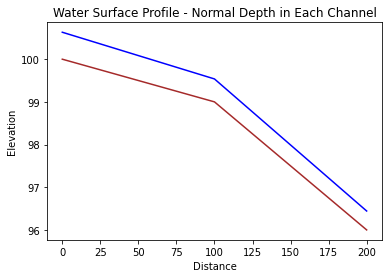

In [25]:
# Now plotting
def plotAline(list1,list2,list3,list4,strx,stry,strtitle): # plot list1 on x, list2 on y, xlabel, ylabel, title
    from matplotlib import pyplot as plt # import the plotting library from matplotlibplt.show()
    plt.plot( list1, list2, color ='brown', marker ='', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.plot( list3, list4, color ='blue', marker ='', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.title(strtitle)# add a title
    plt.ylabel(stry)# add a label to the x and y-axes
    plt.xlabel(strx)
    plt.show() # display the plot
    return #null return

plotAline(location,elevation,location,head,'Distance','Elevation','Water Surface Profile - Normal Depth in Each Channel')

## SWMM

Now we will do the same simulation in SWMM - we will find it is a lot easier to set-up and run.

---

## Gradually Varied Steady Flow

### Fixed Depth Change, Variable Spatial Step
The fixed-step refers to specified changes in depth for which we solve to find the variable spatial steps. The method is a very simple method for computing water surface profiles in prismatic channels. A prismatic channel is a channel of uniform cross sectional geometry with constant bed (topographic) slope.

In such channels with smooth (non-jump) steady flow the continunity and momentum equations are: 

$$Q = AV $$

where where $Q$ is volumetric discharge, $A$ is cross sectional flow area, and $V$ is the mean section velocity; and: 

$$\frac{V}{g} \frac{dV}{dx}+\frac{dh}{dx} = S_o - S_f$$ 

where $h$ is the flow depth (above the bottom), and $x$ is horizontal the distance along the channel.

For the variable step method, the momentum equation is rewritten as a difference equation (after application of calculus to gather terms) then rearranged to solve for the spatial step dimension .

$$ \frac{\frac{V^2_{i+1}}{2g}-\frac{V^2_{i}}{2g}}{\Delta x} + \frac{h_{i+1}-h_{i}}{\Delta x} = S_o - \bar{S_f} $$

where $S_f$ is the average slope of the energy grade line between two sections (along a
reach of length $\Delta x$, the unknown value). Rearrangement to isolate $\Delta x$ produces an explicit update equation that can be evaluated to find the different values of $\Delta x$ associated with different flow depths. The
plot of the accumulated spatial changes versus the sum of the flow depth and bottom elevation is the water surface profile.

$$\frac{(h_{i+1} + \frac{V^2_{i+1}}{2g})  -  (h_{i} +\frac{V^2_{i}}{2g}) }{S_o - \bar{S_f} } = \Delta x $$

The distance between two sections with known discharges is computed using the
equation, all the terms on the left hand side are known values. The mean energy
gradient ($\bar{S_f}$ ) is computed from the mean of the velocity, depth, area, and hydraulic
radius for the two sections.

The friction slope can be computed using Manning's, Chezy, or the Darcy-Weisbach friction equations adapted for non-circular, free-surface conduits.

The equation here is written moving upstream, direction matters for indexing. Thus position $i+1$
is assumed upstream of position $i$ in this notebook. Such directional convention is unusual in
numerical methods and analysts need to use care when developing their own tools or using other
tools. A clever analyst need not rewrite code, but simple interchange of upstream and downstream
depths can handle both backwater and front-water curves.

## Scripting an Algorithm

Here the method is illustrated in  to illustrate the tool as a programming environment.
First we build a set of utility functions, these will be used later in the `backwater`
function

The listings below are utility functions for rectangular channels for flow area given channel
depth and width and wetted perimeter given depth and width. Different geometries will need different functions (probably by numerical methods rather than actual functional relationships).


The first listing is a depth-area function for rectangular geometry.

In [177]:
# Depth-Area function for rectangular channel
def area(depth,width):
    area=depth*width;
    return(area)

The next listing is a depth wetted-perimeter function for a rectangular geometry.

In [177]:
# Depth-Wetted perimeter function for rectangular channel
def perimeter(depth,width):
    perimeter=2*depth+width;
    return(perimeter)

Listing below is a listing of the code for the hydraulic radius (ratio of the above results),
this is a generic function, it does not need to know the flow geometry

In [177]:
# Hydraulic radius function
def radius(area,perimeter):
    radius=area/perimeter;
    return(radius)

The next section is a listing of code for the friction slope given Manning's n, discharge,
hydraulic radius, and flow area. This function implicitly assumes SI units
(the 1.49 constant in U.S. Customary units is not present). For U.S. Customary units
either add the constant or convert the US units into equivalent SI units.

In [177]:
# Friction slope function
def slope_f(discharge,mannings_n,area,radius):
    slope_f=(discharge**2)*(mannings_n**2)/( (radius**(4./3))*(area**2) ); #compute friction slope
    return(slope_f)

In [177]:
# 2-point average
def avg2point(x1,x2):
    avg2point=0.5*(x1+x2);
    return(avg2point)

The semi-colons in the functions are probably unnecessary, but have value because it
forces the expression to its left to be evaluated and helps prevent ambiguous code.
Also notice the use of indention as a scope delimiter, the delimiter is required. 

## Describe the actual BW computes

At this point, we have 5 useful, testable functions (and we should test before
the next step.

The next listing is the step-backwater method implemented as a function. This function
computes the space steps, changes in depth, etc. as per the algorithm. The function illustrates count
controlled repetition (for loops), list indexing, and use of the utility functions to
make the code readable as well as ensure that the parts work before the whole program
is assembled. This concept is really crucial, if you can build a tool of parts that are
known to work, it helps keep logic errors contained to known locations.

In [252]:
# Backwater curve function
def backwater(begin_depth,end_depth,how_many,discharge,width,mannings_n,slope):
#
## Example function call
##  zz<-backwater(begin_depth=8,end_depth=5,how_many=30,discharge=55.4,width=5,mannings_n=0.02,slope=0.001)
## Numerical values are values used in essay, they correspond to a particuar example from Koutitas 1983
#
# Other functions must exist otherwise will spawn errors
#
# Prepare space for vectors
    twog=2.0*9.8
    depth=[]  # numeric vector for depths
    velocity=[]  # numeric vector for velocities
    deltax=[] # numeric vector for spatial steps
    distance=[] # space for computing cumulative distances
    bse=[] # numeric vector for bottom elevations
    wse=[] # numeric vector for water surface elevations
    delta_depth=(begin_depth-end_depth)/(how_many)  # change in depth for finding spatial steps
    #print(delta_depth)
    depth.append(begin_depth) # assign downstream value
    for i in range(1,how_many):
        depth.append(depth[0] - (i+1)*delta_depth) # uniform depths
    for i in range(0,how_many):
        velocity.append(discharge/area(depth[i],width))
    for i in range(0,how_many-1):
        depth_bar=avg2point(depth[i+1],depth[i]); #compute average depth in reach
        area_bar=area(depth_bar,width); #compute average area in reach
        perimeter_bar=perimeter(depth_bar,width); #compute average wetted perimeter
        radius_bar=radius(area_bar,perimeter_bar); #compute average hydraulic radius
        friction=slope_f(discharge,mannings_n,area_bar,radius_bar) #compute friction slope
        snrgup =(depth[i+1]+((velocity[i+1]**2)/twog))
        snrgdn =(depth[i] + ((velocity[i]**2)/twog))
        step =(snrgup - snrgdn)/(slope-friction) # compute change in distance for each change in depth
        deltax.append(step)
    distance.append(0.0)
    bse.append(0.0)
    for i in range(1,how_many):
        distance.append(distance[i-1]+deltax[i-1]); # spatial distances
        bse.append(bse[i-1]-deltax[i-1]*slope); # bottom elevations
    for i in range(0,how_many):
        wse.append(bse[i]+depth[i]) # water surface elevations
    return(distance,wse,bse,depth,deltax,velocity)

### Function call with plotting

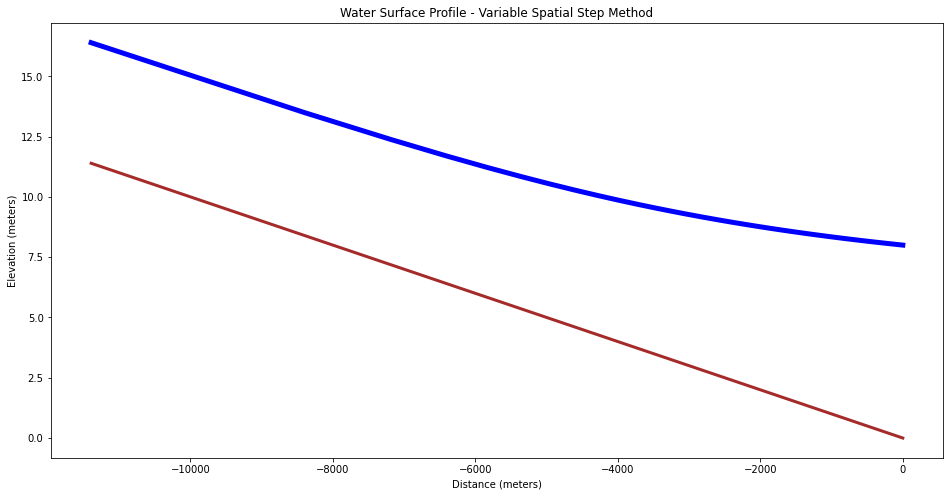

In [263]:
# call the function - output is a tuple, use this fact in the plotting build
output = backwater(begin_depth=8.0,end_depth=5.0,how_many=31,discharge=55.4,width=5.0,mannings_n=0.02,slope=0.001)
# Now plot the water surface profile
import matplotlib.pyplot
myfigure = matplotlib.pyplot.figure(figsize = (16,8)) # generate a object from the figure class, set aspect ratio
# Built the plot
matplotlib.pyplot.plot(output[0], output[2],  color ='brown', linewidth=3)
matplotlib.pyplot.plot(output[0], output[1],  color ='blue', linewidth=5)
matplotlib.pyplot.ylabel("Elevation (meters)")
matplotlib.pyplot.xlabel("Distance (meters)")
mytitle = "Water Surface Profile - Variable Spatial Step Method"
matplotlib.pyplot.title(mytitle)
matplotlib.pyplot.show()

## References
Koutitas, C. G. 1983. Elements of Computational Hydraulics. ISBN 0-412-00361-9. Pentech Press Ltd. London. (Chapter 4) [http://54.243.252.9/ce-5362-psuedo-course/3-Readings/PracticalComputationalHydraulics-Kousitas/ElementsOfComputationalHydraulics.pdf](http://54.243.252.9/ce-5362-psuedo-course/3-Readings/PracticalComputationalHydraulics-Kousitas/ElementsOfComputationalHydraulics.pdf)

Roberson, J. A., Cassidy, J.J., and Chaudry, M. H., (1988) Hydraulic Engineering, Houghton Mifflin Co (Chapter 10) [http://54.243.252.9/ce-5362-psuedo-course/3-Readings/HydraulicEngineering/](http://54.243.252.9/ce-5362-psuedo-course/3-Readings/HydraulicEngineering/)

Sturm T.W (2001) Open Channel Hydraulics, 1ed., McGraw-Hill, New York. Note: This PDF is from an international edition published in Singapore. [http://54.243.252.9/ce-5362-psuedo-course/3-Readings/OpenChannelHYdraulics/](http://54.243.252.9/ce-5362-psuedo-course/3-Readings/OpenChannelHYdraulics/)

Cunge, J.A., Holly, F.M., Verwey, A. (1980). Practical Aspects of Computational
River Hydraulics. Pittman Publishing Inc. , Boston, MA. pp. 7-50